In [2]:
from segmentation_network import build_segmenter, preproc_dataset
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______



Using gpu device 0: GeForce GTX 660 (CNMeM is disabled)


In [3]:
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

In [4]:
model_loc = 'annot_full_32_100r'
dset_loc = 'TESTannot_full_32_100r'

In [5]:
with open(join(dataset_loc, "Flukes/patches/%s/model.pkl" % model_loc), 'r') as f:
    model = pickle.load(f)

test_dset = load_dataset(join(dataset_loc, "Flukes/patches/%s" % dset_loc))


Loading /home/zach/data/Flukes/patches/TESTannot_full_32_100r
Took 0.82 seconds


In [6]:
segmenter = build_segmenter()
ll.set_all_param_values(segmenter, model)

X = T.tensor4()
segmenter_out = ll.get_output(segmenter, X, deterministic=True)
segmenter_fn = tfn([X], segmenter_out)

dset_for_model = {section:preproc_dataset(test_dset[section]) for section in test_dset}

segmentation_outputs = segmenter_fn(dset_for_model['train']['X'])

segmentation_outputs_valid = segmenter_fn(dset_for_model['valid']['X'])

print(np.average(np.argmax(dset_for_model['valid']['y'],axis=1) == np.argmax(segmentation_outputs_valid,axis=1)))

0.88996887207


[[2 2 2 ..., 2 2 2]
 [2 2 2 ..., 2 2 2]
 [2 2 2 ..., 2 2 2]
 ..., 
 [2 2 2 ..., 2 2 2]
 [2 2 2 ..., 2 2 2]
 [2 2 2 ..., 2 2 2]]


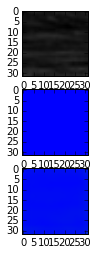

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_output(originals, true_labels, outputs, ind):
    original = (originals[ind].swapaxes(0,2)) * 255 + 128
    #original = originals[ind]
    true_label = true_labels[ind].swapaxes(0,2)
    output = outputs[ind].swapaxes(0,2)#.reshape(outputs.shape[3], outputs.shape[2], outputs.shape[1])
    print(np.argmax(output, axis=2))
    #print(output)
    f, ax = plt.subplots(3)
    ax[0].imshow(original)
    ax[1].imshow(true_label)
    ax[2].imshow(output)

show_output(dset_for_model['valid']['X'], dset_for_model['valid']['y'], segmentation_outputs_valid, 
            np.random.randint(segmentation_outputs_valid.shape[0]))

0.376784


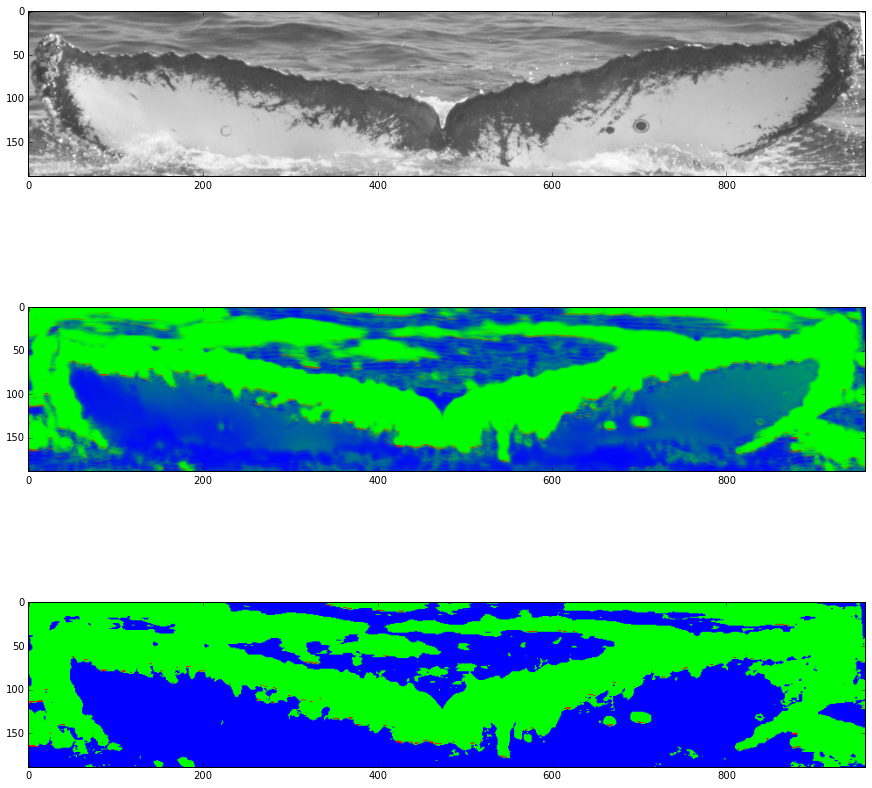

In [14]:
import glob
import random
import cv2
from itertools import product

def argmaxed_img(img):
    # assume channel axis is axis 3
    argmaxed = np.argmax(img, axis=2)
    coords = zip(*[(i,j,argmaxed[i,j]) for i, j in product(range(argmaxed.shape[0]),
                                                      range(argmaxed.shape[1]))])
    new_img = np.zeros(img.shape)
    new_img[coords] = 1
    return new_img

def prepare_img(img):
    img_normed = ((np.array(img, dtype='float32') - 128) / 255.).swapaxes(0,2)
    img_normed = img_normed.reshape(1, *img_normed.shape)
    return img_normed

from scipy.stats import entropy
imgs_dir = join(dataset_loc, "Flukes/CRC_combined constrained/")
all_imgs = glob.glob(join(imgs_dir, "*"))
def see_random_image(all_imgs, network_fn):
    imgn = random.choice(all_imgs)
    #imgn = join(dataset_loc, 'Flukes/CRC_combined constrained/11429-JAC00-27-17a.jpg')
    img = cv2.imread(imgn)
    img_normed = prepare_img(img)
    img_output = network_fn(img_normed)
    
    print(np.average(entropy(img_output[0])))
    img_output = img_output.swapaxes(1,3)[0]
    hard_output = argmaxed_img(img_output)
    f, ax = plt.subplots(3, figsize=(15,15))
    ax[0].imshow(img)
    #plt.gray()
    ax[1].imshow(img_output)
    #plt.gray()
    ax[2].imshow(hard_output)
see_random_image(all_imgs, segmenter_fn)

In [12]:
rand_imgfn = random.choice(all_imgs)
rand_img = cv2.imread(rand_imgfn)
img_normed = np.array((rand_img - 128) / 255., dtype='float32').swapaxes(0,2)
img_normed = img_normed.reshape(1, *img_normed.shape)

img_output = segmenter_fn(img_normed)
#img_output = img_output.swapaxes(1,3)[0]


In [15]:
# Whole image accuracy on the images we have segmented
whole_loc = "annot_full_whole"
whole_dset = load_dataset(join(dataset_loc, "Flukes/patches/%s" % whole_loc))

Loading /home/zach/data/Flukes/patches/annot_full_whole
Took 476.02 seconds


In [19]:
section = 'train'
accuracies = []
for img, segmentation in zip(*whole_dset[section]):
    img = prepare_img(img)
    img_output = segmenter_fn(img).swapaxes(1,3)[0]
    accuracies.append(np.mean(np.argmax(segmentation, axis=2) == np.argmax(img_output, axis=2)))

In [23]:
print(np.average(accuracies))
print(np.std(accuracies))

0.860345776515
0.12711285652


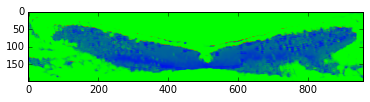

In [26]:
plt.imshow(segmenter_fn(prepare_img(whole_dset['train'][0][149])).swapaxes(1,3)[0])